In [ ]:
# Data commands:
# `python comet_download.py --project=feature-recycling-nlg-ablation-v5 --n_threads=8`
# `python comet_download.py --project=feature-recycling-nlg-ablation-v5-step-size --n_threads=8`

In [69]:
import itertools
import re
import sys

sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm

from IPython.display import display

from plotting_utils import *

sns.set_theme('notebook', 'white')
%matplotlib inline

In [ ]:
save_path = 'figures/'
config_data_path = 'data/feature-recycling-nlg-ablation-v5_params.csv'
run_data_path = f'data/feature-recycling-nlg-ablation-v5_metrics.csv'

step_sizes_config_data_path = 'data/feature-recycling-nlg-ablation-v5-step-size_params.csv'
step_sizes_run_data_path = f'data/feature-recycling-nlg-ablation-v5-step-size_metrics.csv'

all_sweeps_config_df = pd.read_csv(config_data_path, index_col=0)
all_sweeps_run_df = pd.read_csv(run_data_path, index_col=0)

step_sizes_all_sweeps_config_df = pd.read_csv(step_sizes_config_data_path, index_col=0)
step_sizes_all_sweeps_run_df = pd.read_csv(step_sizes_run_data_path, index_col=0)

all_sweeps_config_df = pd.concat([all_sweeps_config_df, step_sizes_all_sweeps_config_df])
all_sweeps_run_df = pd.concat([all_sweeps_run_df, step_sizes_all_sweeps_run_df])

# Remove duplicate config rows, ignoring run_id column
all_sweeps_config_df = all_sweeps_config_df.drop_duplicates(
    subset = [col for col in all_sweeps_config_df.columns if col != 'run_id'],
    keep = 'last',
)
valid_run_ids = set(all_sweeps_config_df['run_id'].unique())
all_sweeps_run_df = all_sweeps_run_df[all_sweeps_run_df['run_id'].isin(valid_run_ids)]
all_sweeps_run_df = all_sweeps_run_df.dropna(subset=['step'])

sweep_names = list(all_sweeps_config_df['sweep_name'].unique())

# Drop all runs where the seed is not [501, 505]
valid_seeds = set([501, 502, 503, 504, 505])
valid_run_ids = set(all_sweeps_config_df[all_sweeps_config_df['seed'].isin(valid_seeds)]['run_id'])
all_sweeps_config_df = all_sweeps_config_df[all_sweeps_config_df['run_id'].isin(valid_run_ids)]
all_sweeps_run_df = all_sweeps_run_df[all_sweeps_run_df['run_id'].isin(valid_run_ids)]

# Split up dfs by sweep name
run_dfs = {}
config_dfs = {}
for sweep_name in sweep_names:
    config_dfs[sweep_name] = all_sweeps_config_df[all_sweeps_config_df['sweep_name'] == sweep_name].reset_index(drop=True)
    # Drop experiments that did not complete
    max_step = config_dfs[sweep_name]['curr_step'].max()
    config_dfs[sweep_name] = config_dfs[sweep_name][config_dfs[sweep_name]['curr_step'] == max_step]
    
    run_ids = set(config_dfs[sweep_name]['run_id'].unique())
    run_dfs[sweep_name] = all_sweeps_run_df[all_sweeps_run_df['run_id'].isin(run_ids)].reset_index(drop=True)

# # Add in an extra baseline df
# config_dfs['baseline'] = config_dfs['distractor_chance'][config_dfs['distractor_chance']['task|distractor_chance'] == 0]
# vanilla_run_ids = set(config_dfs['baseline']['run_id'].unique())
# run_dfs['baseline'] = run_dfs['distractor_chance'][run_dfs['distractor_chance']['run_id'].isin(vanilla_run_ids)]

In [ ]:
# Break up distractor chance and non-stationary sub-sweeps

### Distractor Chance ###

is_standard_normal = (config_dfs['distractor_chance']['task|distractor_mean_range'] == '[0.0,0.0]').values
standard_normal_run_ids = config_dfs['distractor_chance'][is_standard_normal]['run_id'].unique()

standard_normal_run_df = run_dfs['distractor_chance'][run_dfs['distractor_chance']['run_id'].isin(standard_normal_run_ids)]
standard_normal_config_df = config_dfs['distractor_chance'][config_dfs['distractor_chance']['run_id'].isin(standard_normal_run_ids)]

non_standard_normal_run_df = run_dfs['distractor_chance'][~run_dfs['distractor_chance']['run_id'].isin(standard_normal_run_ids)]
non_standard_normal_config_df = config_dfs['distractor_chance'][~config_dfs['distractor_chance']['run_id'].isin(standard_normal_run_ids)]

run_dfs['standard_distractor_chance'] = standard_normal_run_df
config_dfs['standard_distractor_chance'] = standard_normal_config_df

run_dfs['distractor_chance'] = non_standard_normal_run_df
config_dfs['distractor_chance'] = non_standard_normal_config_df

### Non-Stationary ###

is_full_ns = (config_dfs['target_flip_rate']['task.n_stationary_layers'] == 0).values
full_ns_run_ids = config_dfs['target_flip_rate'][is_full_ns]['run_id'].unique()

full_ns_run_df = run_dfs['target_flip_rate'][run_dfs['target_flip_rate']['run_id'].isin(full_ns_run_ids)]
full_ns_config_df = config_dfs['target_flip_rate'][config_dfs['target_flip_rate']['run_id'].isin(full_ns_run_ids)]

non_full_ns_run_df = run_dfs['target_flip_rate'][~run_dfs['target_flip_rate']['run_id'].isin(full_ns_run_ids)]
non_full_ns_config_df = config_dfs['target_flip_rate'][~config_dfs['target_flip_rate']['run_id'].isin(full_ns_run_ids)]

run_dfs['full_ns'] = full_ns_run_df
config_dfs['full_ns'] = full_ns_config_df

run_dfs['partial_ns'] = non_full_ns_run_df
config_dfs['partial_ns'] = non_full_ns_config_df

del run_dfs['target_flip_rate']
del config_dfs['target_flip_rate']

In [13]:
{k: len(v) for k, v in config_dfs.items()}

{'distractor_chance': 240,
 'target_hidden_dim': 300,
 'target_input_features': 300,
 'target_noise': 300,
 'standard_distractor_chance': 240,
 'full_ns': 360,
 'partial_ns': 360}

### Extract best initial step size runs for each hidden dim and ablation var combination

In [14]:
sweep_ablation_vars = {
   'distractor_chance': 'task|distractor_chance',
   'standard_distractor_chance': 'task|distractor_chance',
   'full_ns': 'task|flip_rate',
   'partial_ns': 'task|flip_rate',
   'target_hidden_dim': 'task|hidden_dim',
   'target_input_features': 'task|n_features',
   'target_noise': 'task|noise_std',
}

In [64]:
best_config_dfs = {}
best_run_dfs = {}

for sweep_name in config_dfs.keys():
    config_df = config_dfs[sweep_name]
    run_df = run_dfs[sweep_name]
    ablation_var = sweep_ablation_vars[sweep_name]
    
    ablation_var_values = config_df[ablation_var].unique()
    
    run_df_with_ablation = run_df.merge(
        config_df[['run_id', ablation_var, 'model|hidden_dim', 'optimizer|learning_rate']], 
        on = 'run_id',
        how = 'left',
    )
    mean_loss = run_df_with_ablation.groupby([
        ablation_var, 'model|hidden_dim', 'optimizer|learning_rate'])['loss'].mean()
    
    # Get the learning rate with lowest loss for each ablation_var and hidden_dim combo
    best_lr = mean_loss.groupby(level=[0,1]).idxmin().apply(lambda x: x[2])
    
    # Get all run_ids that achieve the best loss for their ablation_var/hidden_dim combo
    best_run_ids = []
    for ablation_val, hidden_dim in itertools.product(
            ablation_var_values, 
            config_df['model|hidden_dim'].unique()):
        best_lr_val = best_lr.loc[ablation_val, hidden_dim]
        group_runs = config_df[
            (config_df[ablation_var] == ablation_val) &
            (config_df['model|hidden_dim'] == hidden_dim)
        ]
        matching_runs = group_runs[group_runs['optimizer|learning_rate'] == best_lr_val]
        assert len(matching_runs) > 0
        assert len(matching_runs) * 3 == len(group_runs), f"{len(matching_runs)} * 3 != {len(group_runs)}"
        best_run_ids.extend(matching_runs['run_id'].tolist())
        
    best_config_dfs[sweep_name] = config_df[config_df['run_id'].isin(best_run_ids)]
    best_run_dfs[sweep_name] = run_df[run_df['run_id'].isin(best_run_ids)]

{k: len(v) for k, v in best_config_dfs.items()}

{'distractor_chance': 80,
 'target_hidden_dim': 100,
 'target_input_features': 100,
 'target_noise': 100,
 'standard_distractor_chance': 80,
 'full_ns': 120,
 'partial_ns': 120}

## Plotting functions

In [65]:
def plot_ablation_figure(
        run_df, config_df, x_col, title, x_label, y_label,
        hue_col='model|hidden_dim', metric_type='cumulative', # {'cumulative', 'final'}
        show_ci=False, plot_baseline=False,
    ):
    if metric_type.lower() == 'cumulative':
        final_step_df = run_df.sort_values('step').groupby('run_id').last().reset_index()
        final_step_df = final_step_df.merge(config_df, on='run_id', how='left')
        y_col = 'cumulative_loss'
        y_label = f'Cumulative {y_label}'

    elif metric_type.lower() == 'final':
        # Get the last 5% of steps for each run
        max_steps_per_run = run_df.groupby('run_id')['step'].max()
        threshold_steps = max_steps_per_run * 0.95

        # Filter for last 5% of steps and calculate mean loss
        final_loss_df = run_df.merge(
            threshold_steps.rename('threshold_step'),
            left_on='run_id',
            right_index=True
        )
        final_loss_df = final_loss_df[final_loss_df['step'] >= final_loss_df['threshold_step']]
        final_loss_df = final_loss_df.groupby('run_id')[['loss', 'mean_prediction_loss']].mean().reset_index()
        
        # Merge with config data
        final_loss_df = final_loss_df.merge(config_df, on='run_id', how='left')
        final_step_df = final_loss_df

        y_col = 'loss'
        y_label = f'{y_label} (Final 5%)'
        
    else:
        raise ValueError(f"Invalid metric type: {metric_type}!")

    # Create a mapping of actual values to evenly spaced positions
    x_values = sorted(final_step_df[x_col].unique())
    x_positions = np.arange(len(x_values))
    x_map = dict(zip(x_values, x_positions))

    # Create temporary column with evenly spaced x positions
    final_step_df['x_position'] = final_step_df[x_col].map(x_map)

    # Create plot with evenly spaced x positions
    sns.lineplot(
        data = final_step_df,
        x = 'x_position',
        y = y_col, 
        hue = hue_col,
        marker = 'o',
        palette = 'deep',
        errorbar = ('ci', 95) if show_ci else None,
    )

    if plot_baseline:
        sns.lineplot(
            data = final_step_df,
            x = 'x_position',
            y = 'mean_prediction_loss',
            color = 'black',
            label = 'Baseline',
        )

    # Customize plot
    plt.grid(True, alpha=0.4)  # Add light grid
    plt.xlim(-0.1, len(x_values) - 0.9)  # Add small padding on both sides
    plt.xticks(x_positions, x_values)  # Use original values as labels
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(title='# Hidden Units')


def plot_ablation_comparison(
        run_df, config_df, x_col, title, x_label, y_label,
        hue_col='model|hidden_dim', figsize=(12, 5), show_ci=False,
        plot_baseline=True,
    ):
    """Creates side-by-side plots comparing cumulative and final metrics.
    
    Args:
        run_df: DataFrame containing run data
        config_df: DataFrame containing config data 
        x_col: Column to plot on x-axis
        title: Title for the overall figure
        x_label: Label for x-axis
        y_label: Label for y-axis
        hue_col: Column to use for line colors
        figsize: Figure size as (width, height) tuple
        show_ci: Whether to show 95% confidence intervals
        plot_baseline: Whether to plot the baseline model
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    plt.sca(ax1)
    plot_ablation_figure(
        run_df = run_df,
        config_df = config_df,
        x_col = x_col,
        title = title,
        x_label = x_label,
        y_label = y_label,
        hue_col = hue_col,
        metric_type = 'cumulative',
        show_ci = show_ci,
        plot_baseline = False,
    )
    
    plt.sca(ax2)
    plot_ablation_figure(
        run_df = run_df,
        config_df = config_df,
        x_col = x_col,
        title = title,
        x_label = x_label,
        y_label = y_label,
        hue_col = hue_col,
        metric_type = 'final',
        show_ci = show_ci,
        plot_baseline = plot_baseline,
    )
    
    plt.tight_layout()

In [66]:
def plot_learning_curves(
        run_df,
        config_df,
        subplot_col = None,
        subplot_values = None,
        n_bins = 200,
        figsize = (12, 10),
        max_cols = 2,
        subplot_col_label = None,
        same_y_axis = True,
        y_col = 'loss',
        y_label = None,
    ):
    """Creates subplots of learning curves for different values of a variable.
    
    Args:
        run_df: DataFrame containing run data
        config_df: DataFrame containing config data
        subplot_col: Column name to split subplots by. If None, creates single plot.
        subplot_values: List of values to plot. If None, uses all unique values
        n_bins: Number of bins for the learning curves
        figsize: Figure size as (width, height) tuple
        max_cols: Maximum number of columns in subplot grid
        subplot_col_label: Label for the subplot column
        same_y_axis: Whether all subplots should share the same y-axis scale
        y_col: Column to plot on y-axis (default: 'loss')
        y_label: Label for y-axis (default: same as y_col)
    """
    # Get full dataset
    plot_df = run_df.merge(config_df, on='run_id', how='left')
    
    # Get subplot values if not provided
    if subplot_col is not None and subplot_values is None:
        subplot_values = sorted(plot_df[subplot_col].unique())
    elif subplot_col is None:
        subplot_values = [None]
    
    # Calculate number of rows/cols for subplots
    n_plots = len(subplot_values)
    n_cols = min(max_cols, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Calculate mid 98% percentile for consistent y-axis if requested
    if same_y_axis:
        filtered_df = plot_df[
            (plot_df[y_col] >= np.percentile(plot_df[y_col], 1)) &
            (plot_df[y_col] <= np.percentile(plot_df[y_col], 99))
        ]
        y_range = filtered_df[y_col].max() - filtered_df[y_col].min()
        y_pad = y_range * 0.1
        y_min = filtered_df[y_col].min() - y_pad
        y_max = filtered_df[y_col].max() + y_pad

    # Get max step value for x-axis limit
    max_step = plot_df['step'].max()

    for i, val in enumerate(subplot_values):
        # Filter for current value if subplot_col exists
        curr_df = plot_df.copy()
        if subplot_col is not None:
            curr_df = plot_df[plot_df[subplot_col] == val].copy()
        
        # Bin data
        curr_df = bin_df(curr_df, n_bins=n_bins)
        curr_df = curr_df[curr_df['model.hidden_dim'].notna()]  # Remove NaN values
        curr_df['model.hidden_dim'] = curr_df['model.hidden_dim'].astype(int)
        
        # Create subplot
        sns.lineplot(
            data = curr_df,
            x = 'step',
            y = y_col,
            hue = 'model.hidden_dim', 
            palette = 'deep',
            errorbar = None,
            ax = axes[i]
        )
        
        # Customize subplot
        axes[i].grid(True, alpha=0.4)
        axes[i].set_xlim(0, max_step)
        if same_y_axis:
            axes[i].set_ylim(y_min, y_max)
        else:
            # Calculate y limits for this subplot
            filtered_curr_df = curr_df[
                (curr_df[y_col] >= np.percentile(curr_df[y_col], 1)) &
                (curr_df[y_col] <= np.percentile(curr_df[y_col], 99))
            ]
            y_range = filtered_curr_df[y_col].max() - filtered_curr_df[y_col].min()
            y_pad = y_range * 0.1
            axes[i].set_ylim(
                filtered_curr_df[y_col].min() - y_pad,
                filtered_curr_df[y_col].max() + y_pad
            )
        
        if subplot_col is not None:
            axes[i].set_title(f'{subplot_col_label if subplot_col_label else subplot_col} = {val}')
        axes[i].set_xlabel('step (binned)')
        axes[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        axes[i].set_ylabel(y_label if y_label else y_col)
        
        # Only show legend on first subplot
        if i > 0:
            axes[i].get_legend().remove()
        else:
            axes[i].legend(title='# Learning Hidden Units')
    
    # Remove any extra subplots
    for i in range(len(subplot_values), len(axes)):
        fig.delaxes(axes[i])
    
    # Add overall title if provided
    if subplot_col_label and subplot_col is not None:
        plt.suptitle(f'Learning Curves for {subplot_col_label}')
    
    plt.tight_layout()

## General Scaling

In [67]:
no_distractor_rows = (best_config_dfs['distractor_chance']['task|distractor_chance'] == 0.0).values
no_distractor_run_ids = best_config_dfs['distractor_chance'][no_distractor_rows]['run_id'].unique()

vanilla_run_df = best_run_dfs['distractor_chance'][best_run_dfs['distractor_chance']['run_id'].isin(no_distractor_run_ids)]
vanilla_config_df = best_config_dfs['distractor_chance'][best_config_dfs['distractor_chance']['run_id'].isin(no_distractor_run_ids)]

Text(0.5, 1.0, 'Learning Curves for Different Sizes of Learning Network')

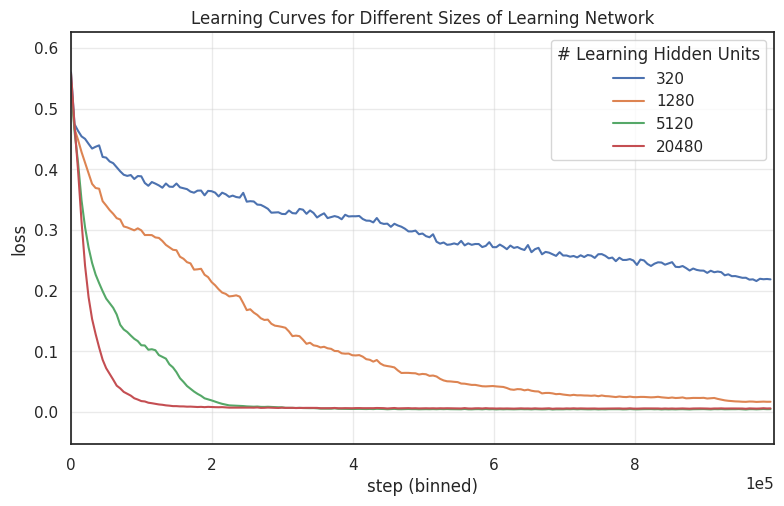

In [68]:
plot_learning_curves(
    run_df = vanilla_run_df,
    config_df = vanilla_config_df,
    subplot_col = None,
    n_bins = 200,
    figsize = (8, 5),
    max_cols = 2,
    same_y_axis = False,
)
plt.title("Learning Curves for Different Sizes of Learning Network")

## Input Feature Count Ablation

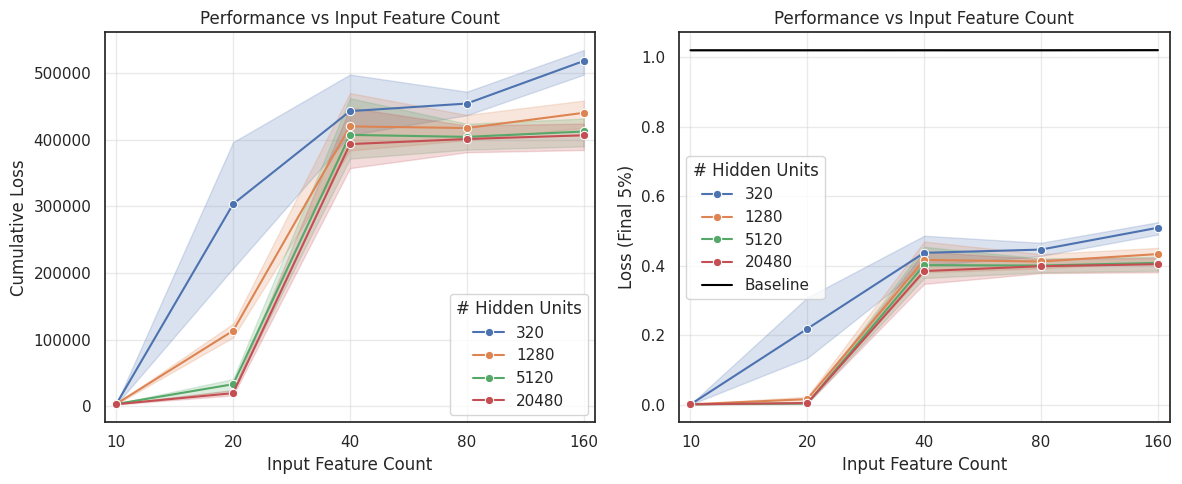

In [70]:
plot_ablation_comparison(
    run_df = best_run_dfs['target_input_features'],
    config_df = best_config_dfs['target_input_features'],
    x_col = 'task|n_features',
    title = 'Performance vs Input Feature Count',
    x_label = 'Input Feature Count',
    y_label = 'Loss',
    show_ci = True,
    plot_baseline = True,
)

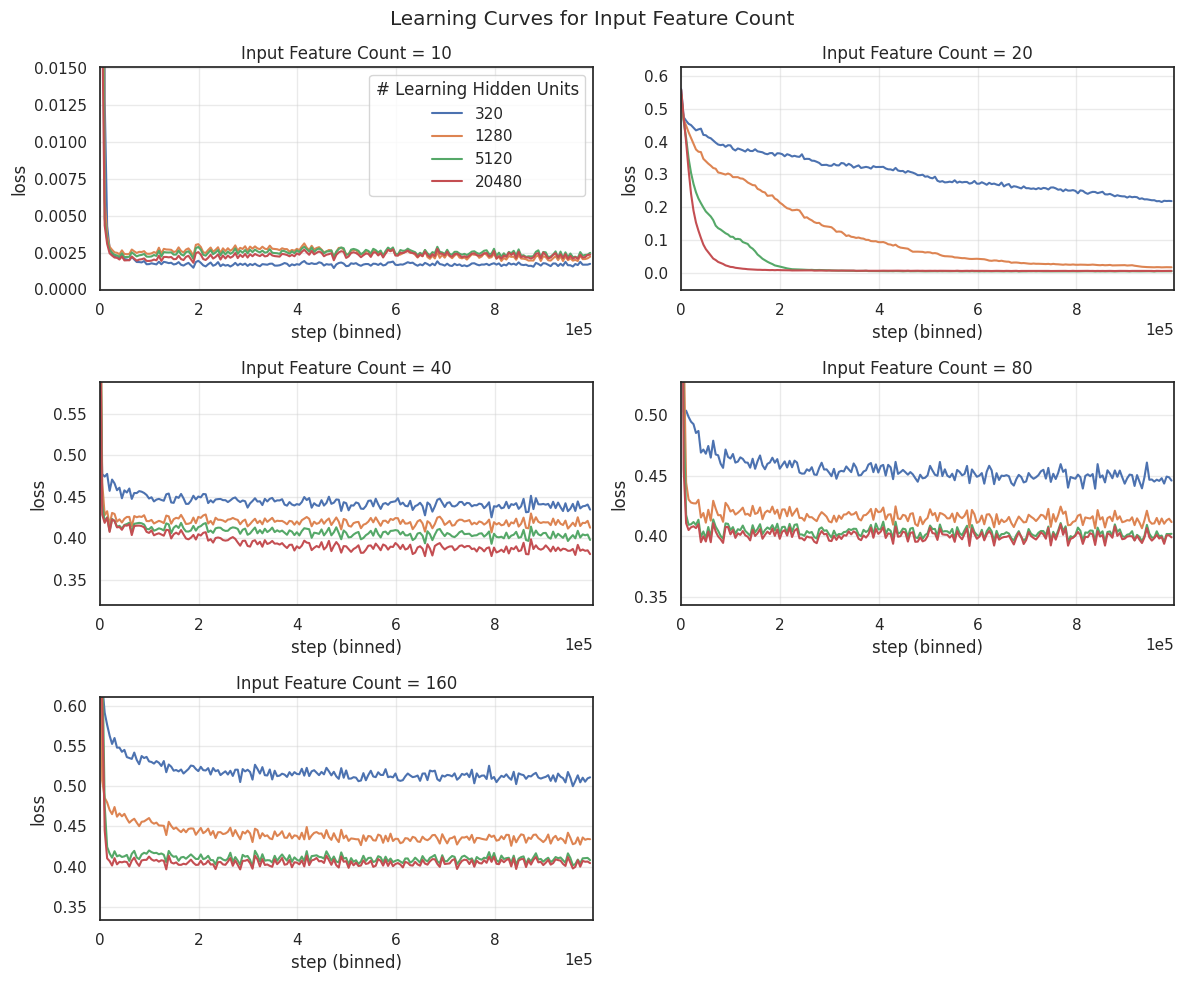

In [71]:
plot_learning_curves(
    run_df = best_run_dfs['target_input_features'],
    config_df = best_config_dfs['target_input_features'],
    subplot_col = 'task|n_features',
    n_bins = 200,
    figsize = (12, 10),
    max_cols = 2,
    same_y_axis = False,
    subplot_col_label = 'Input Feature Count',
)

## Target Hidden Dim Ablation

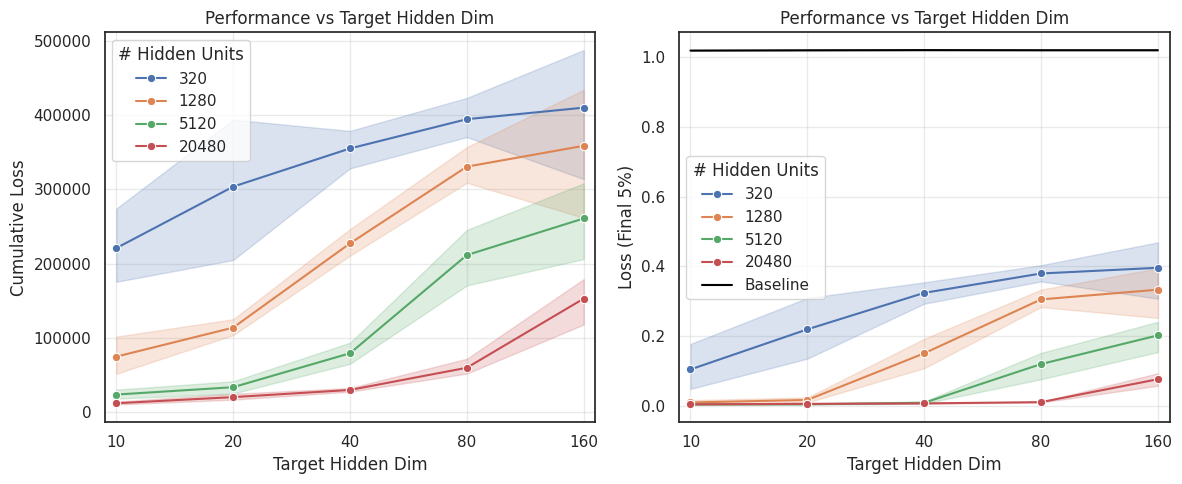

In [72]:
plot_ablation_comparison(
    run_df = best_run_dfs['target_hidden_dim'],
    config_df = best_config_dfs['target_hidden_dim'],
    x_col = 'task|hidden_dim',
    title = 'Performance vs Target Hidden Dim',
    x_label = 'Target Hidden Dim',
    y_label = 'Loss',
    show_ci = True,
)

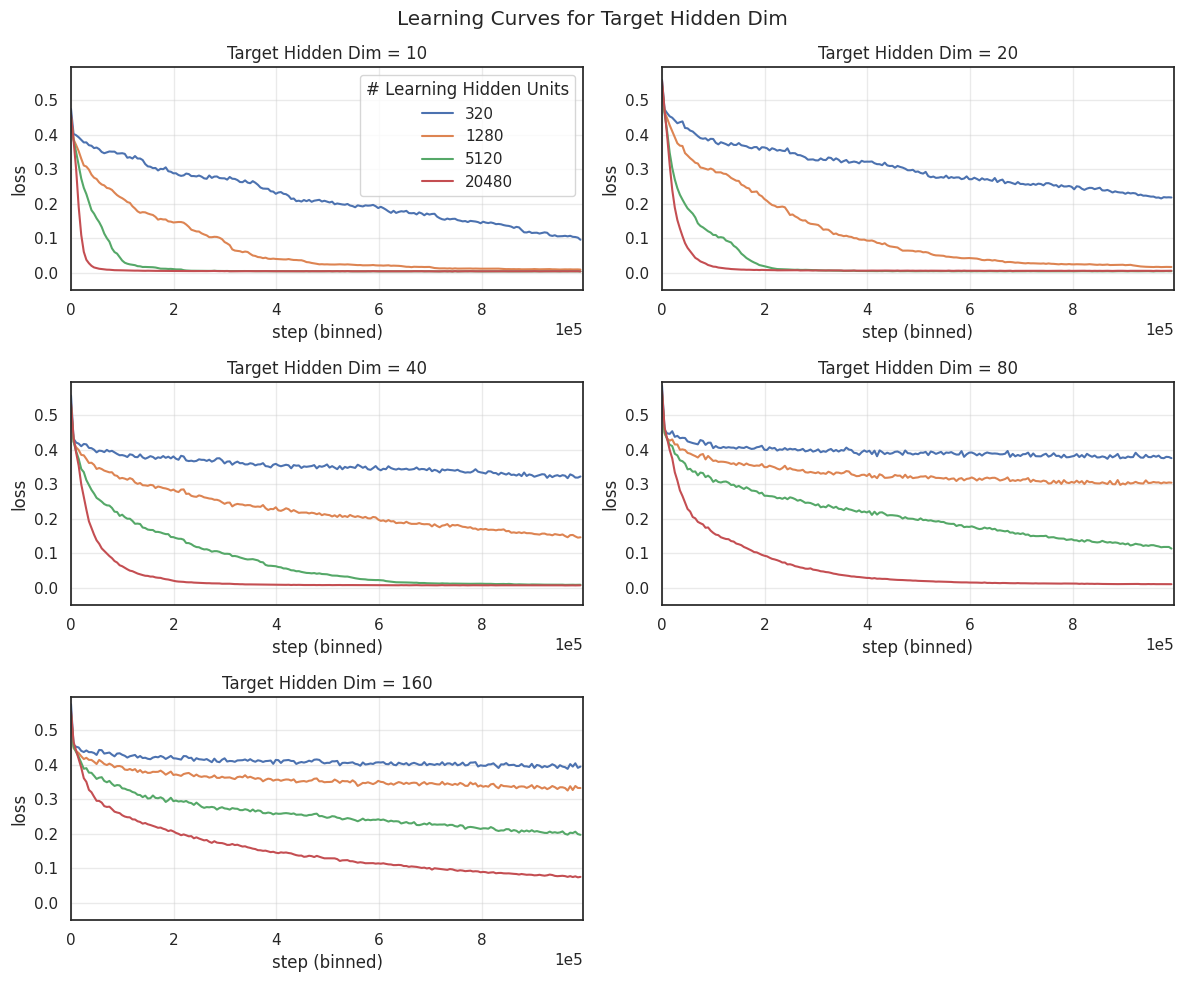

In [73]:
plot_learning_curves(
    run_df = best_run_dfs['target_hidden_dim'],
    config_df = best_config_dfs['target_hidden_dim'],
    subplot_col = 'task|hidden_dim',
    n_bins = 200,
    figsize = (12, 10),
    max_cols = 2,
    subplot_col_label = 'Target Hidden Dim',
)

## Distractor Count Ablation

### Standard Normal Distractors

In [75]:
best_config_dfs.keys()

dict_keys(['distractor_chance', 'target_hidden_dim', 'target_input_features', 'target_noise', 'standard_distractor_chance', 'full_ns', 'partial_ns'])

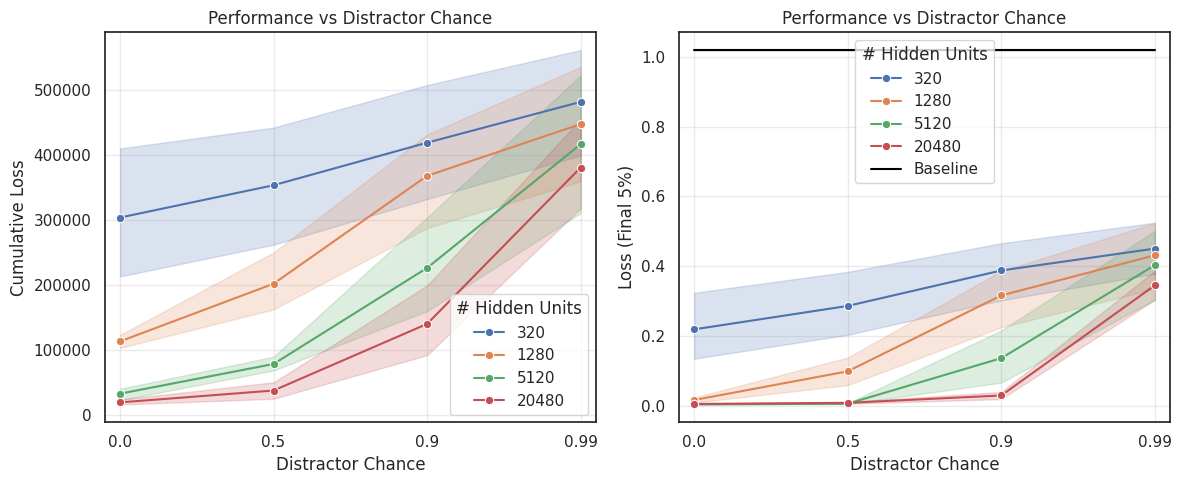

In [76]:
plot_ablation_comparison(
    run_df = best_run_dfs['standard_distractor_chance'],
    config_df = best_config_dfs['standard_distractor_chance'],
    x_col = 'task|distractor_chance',
    title = 'Performance vs Distractor Chance',
    x_label = 'Distractor Chance',
    y_label = 'Loss',
    show_ci = True,
)

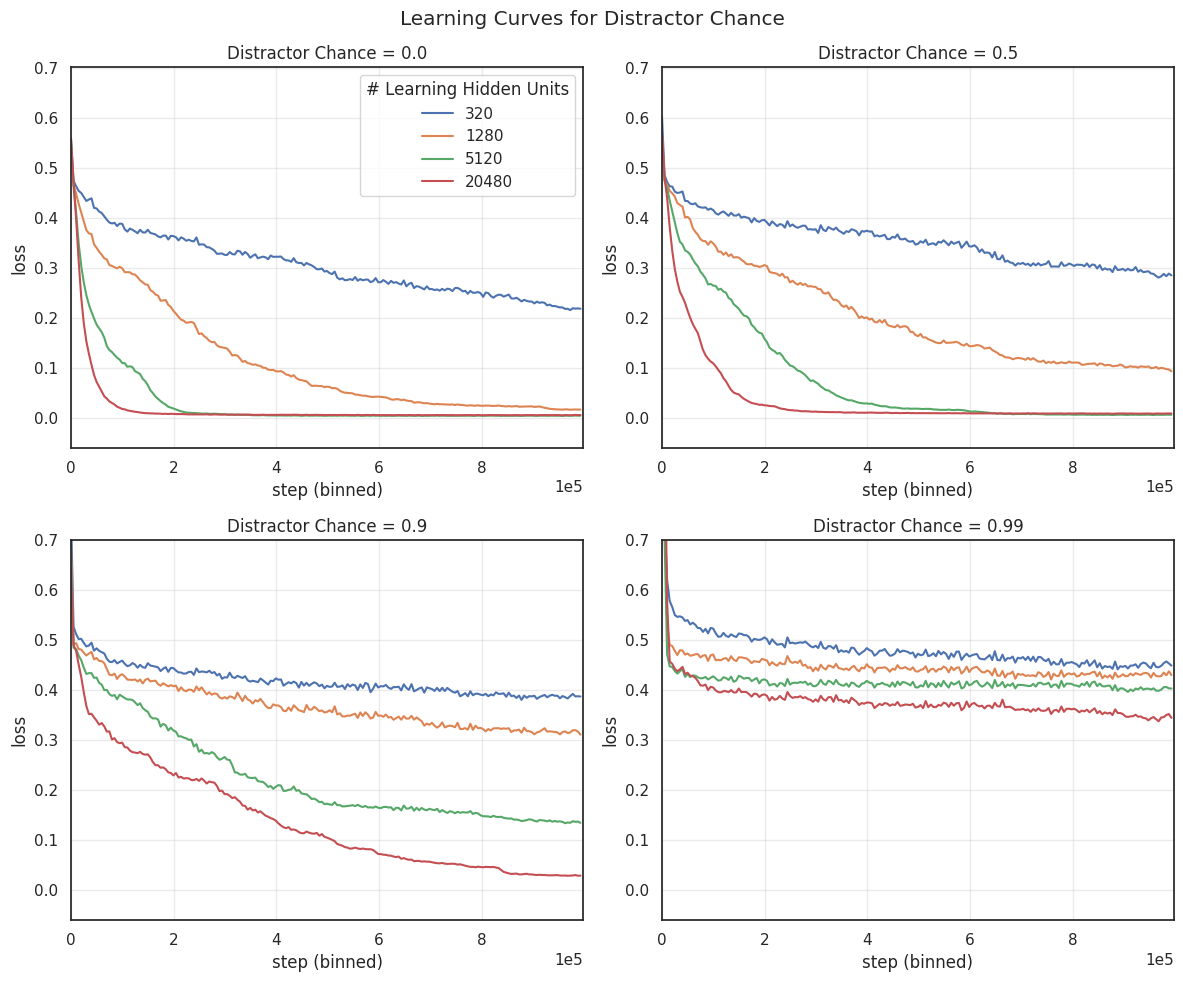

In [77]:
plot_learning_curves(
    run_df = best_run_dfs['standard_distractor_chance'],
    config_df = best_config_dfs['standard_distractor_chance'],
    subplot_col = 'task|distractor_chance',
    n_bins = 200,
    figsize = (12, 10),
    max_cols = 2,
    subplot_col_label = 'Distractor Chance',
)

### Non-standard Normal Distractors

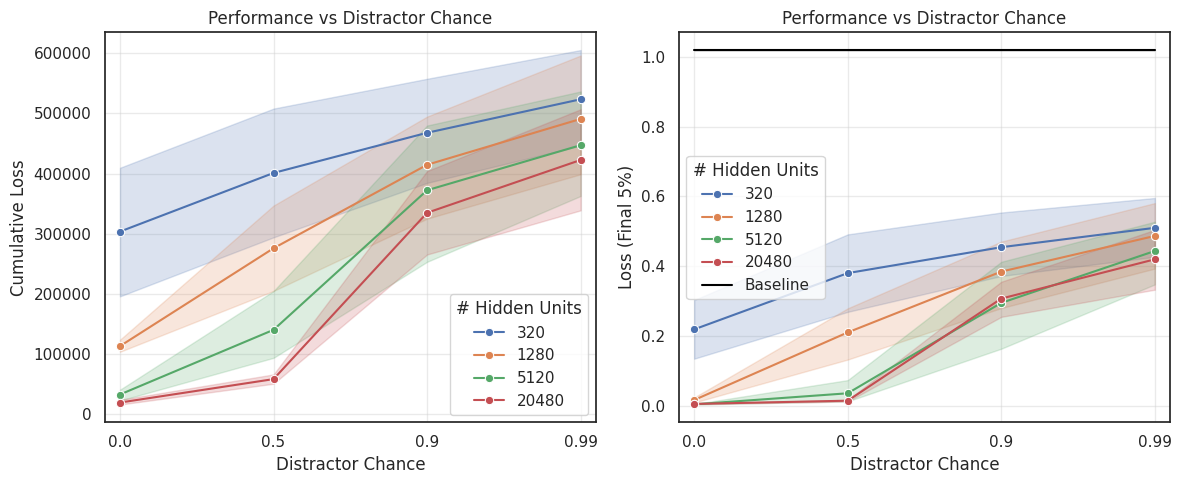

In [78]:
plot_ablation_comparison(
    run_df = best_run_dfs['distractor_chance'],
    config_df = best_config_dfs['distractor_chance'],
    x_col = 'task|distractor_chance',
    title = 'Performance vs Distractor Chance',
    x_label = 'Distractor Chance',
    y_label = 'Loss',
    show_ci = True,
)

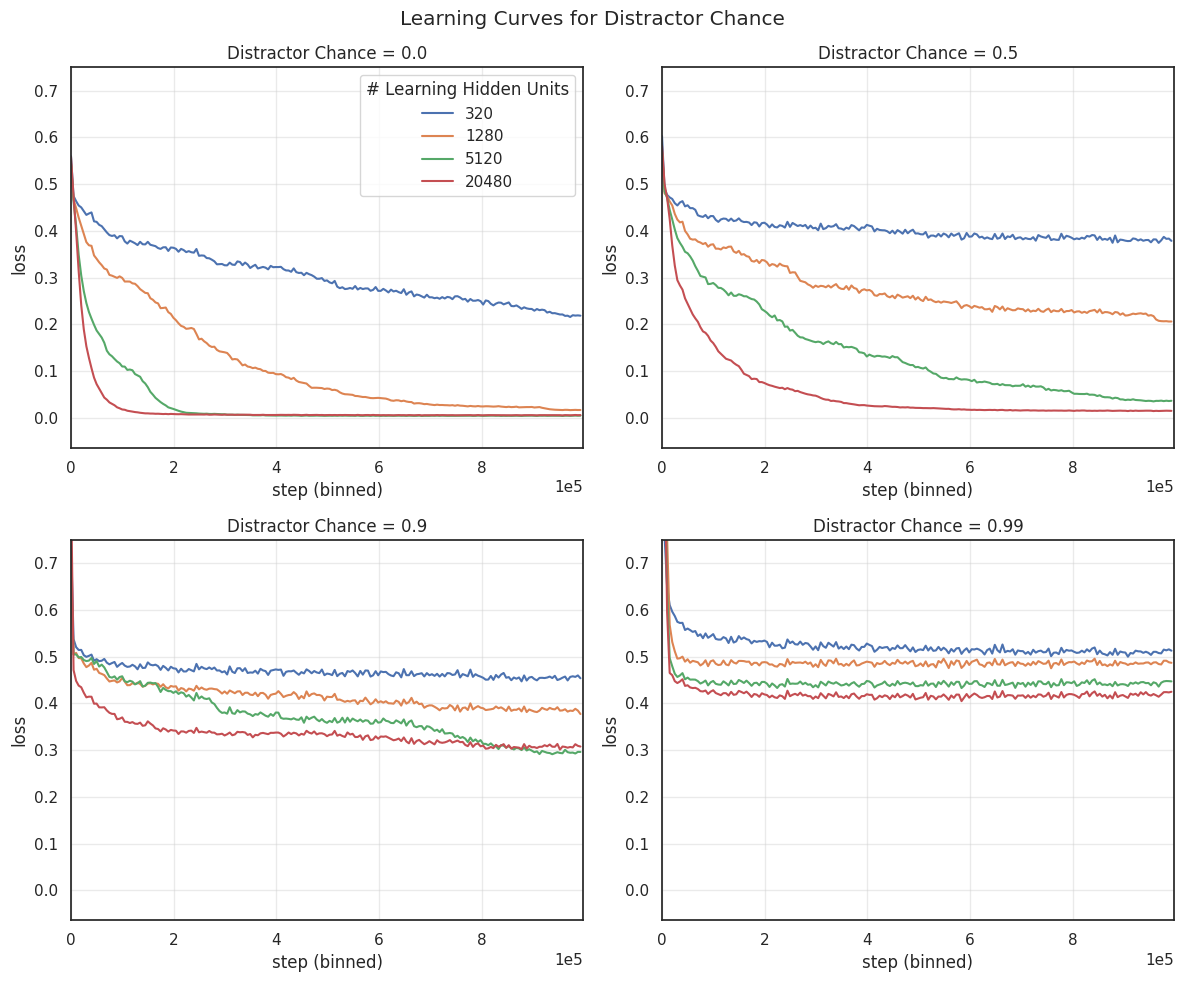

In [79]:
plot_learning_curves(
    run_df = best_run_dfs['distractor_chance'],
    config_df = best_config_dfs['distractor_chance'],
    subplot_col = 'task|distractor_chance',
    n_bins = 200,
    figsize = (12, 10),
    max_cols = 2,
    subplot_col_label = 'Distractor Chance',
)

## Noisy Target Ablation

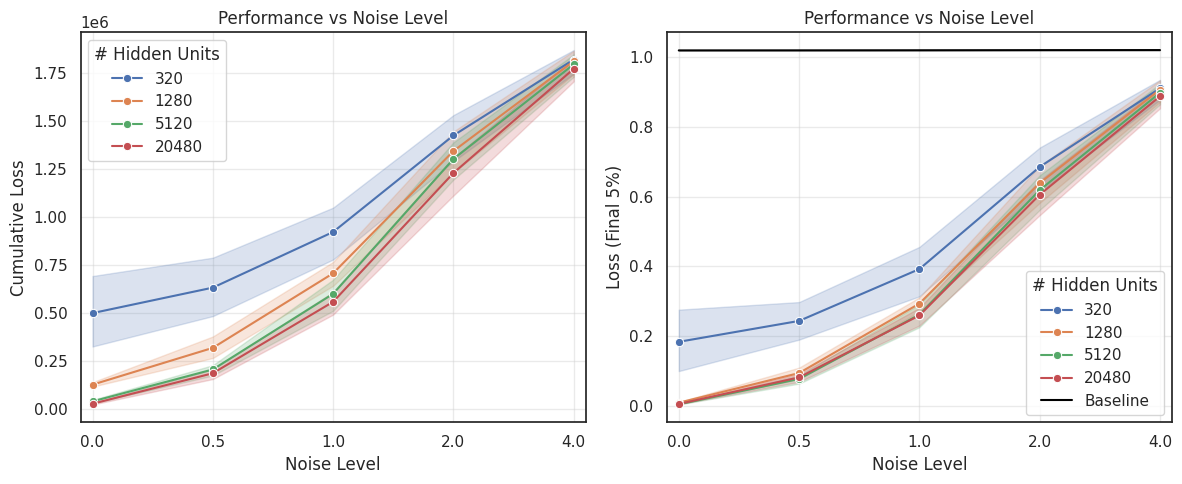

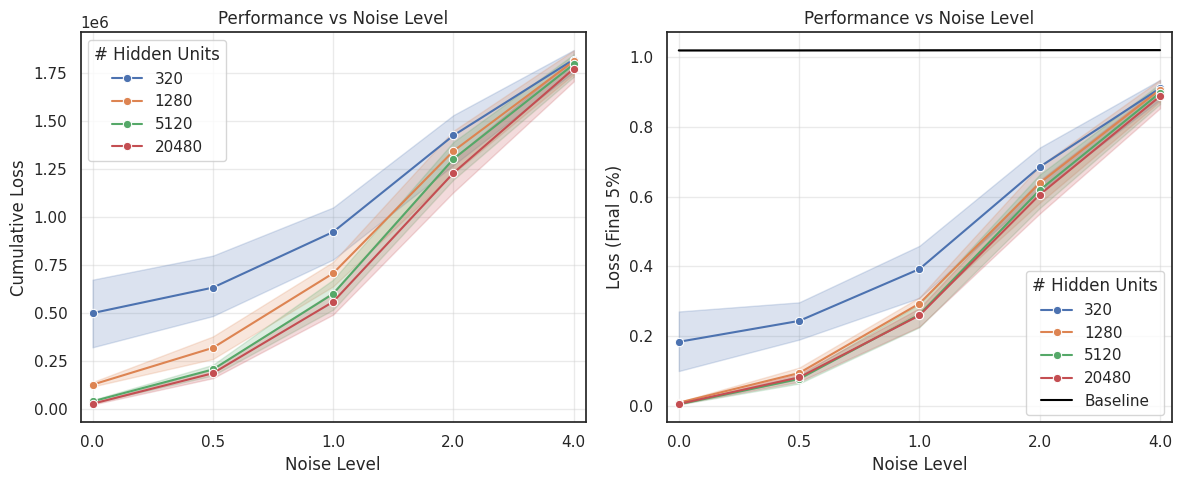

In [86]:
plot_ablation_comparison(
    run_df = best_run_dfs['target_noise'],
    config_df = best_config_dfs['target_noise'],
    x_col = 'task|noise_std',
    title = 'Performance vs Noise Level',
    x_label = 'Noise Level',
    y_label = 'Loss',
    show_ci = True,
)
plt.show()

plot_ablation_comparison(
    run_df = best_run_dfs['target_noise'],
    config_df = best_config_dfs['target_noise'],
    x_col = 'task|noise_std',
    title = 'Performance vs Noise Level',
    x_label = 'Noise Level',
    y_label = 'Loss',
    show_ci = True,
)
# for ax in plt.gcf().get_axes():
#     ax.set_yscale('log')

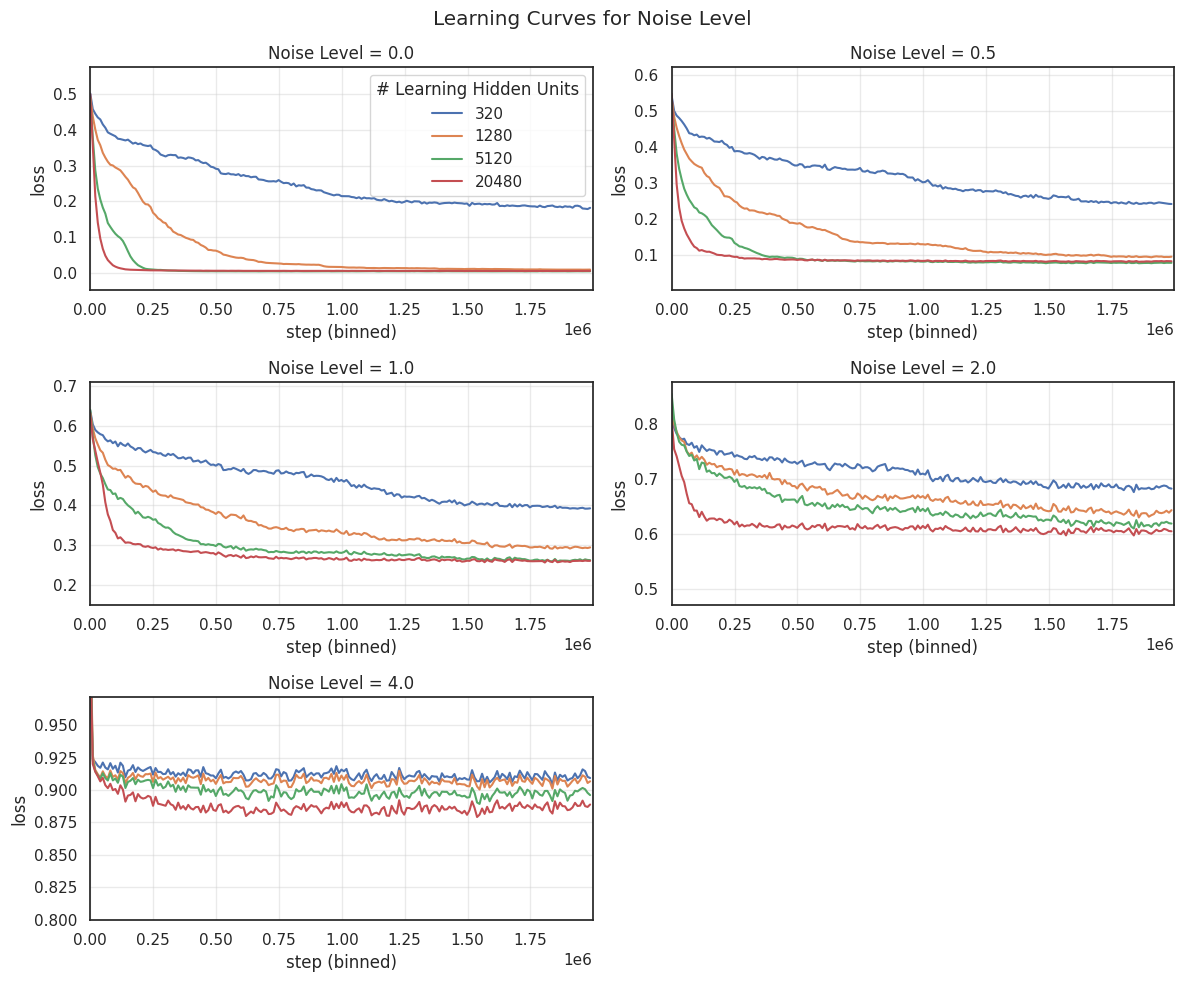

In [82]:
plot_learning_curves(
    run_df = best_run_dfs['target_noise'],
    config_df = best_config_dfs['target_noise'],
    subplot_col = 'task|noise_std',
    n_bins = 200,
    figsize = (12, 10),
    max_cols = 2,
    subplot_col_label = 'Noise Level',
    same_y_axis = False,
)

## Target Non-Stationarity Ablation

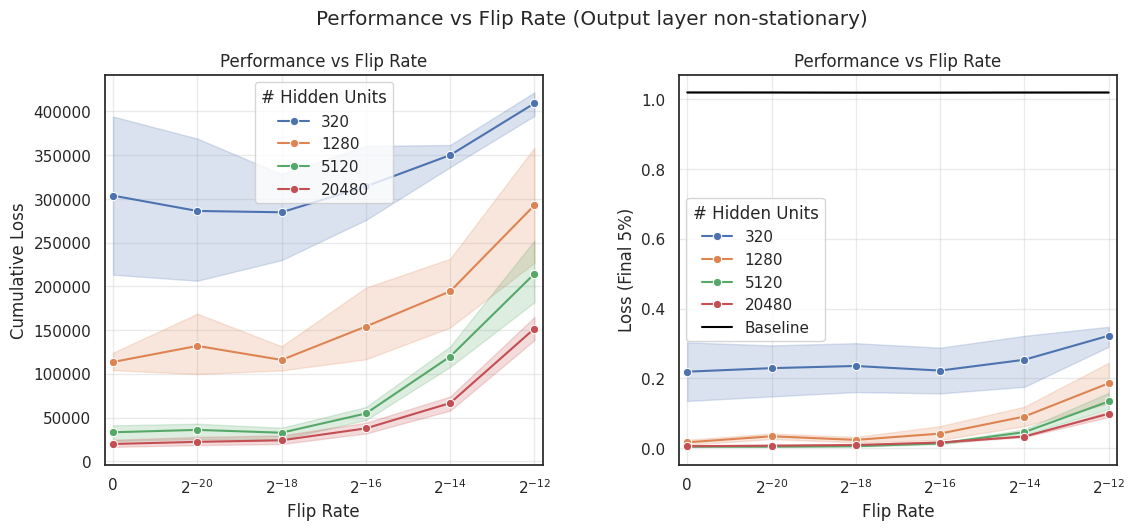

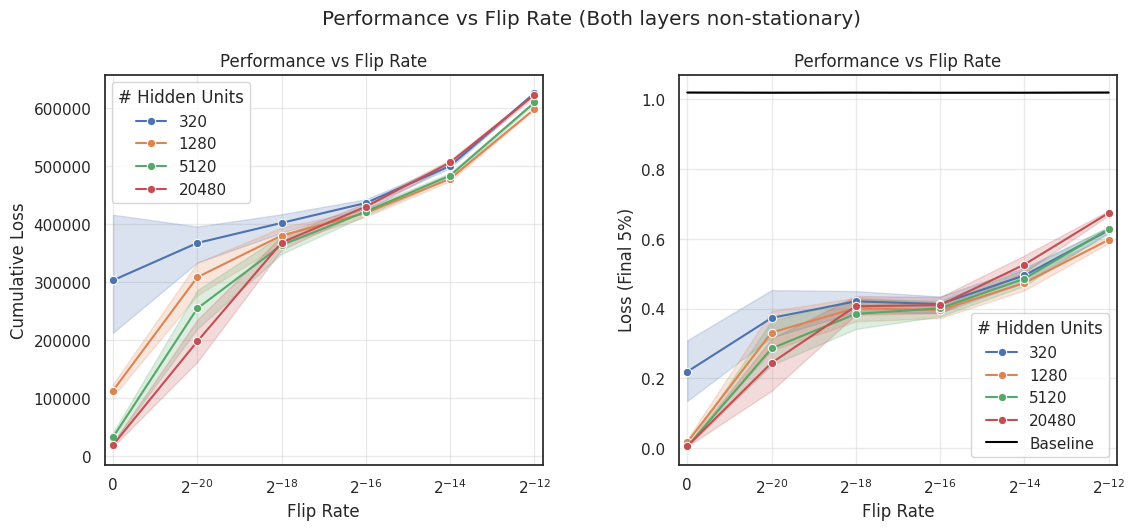

In [84]:
# Plot performance with 1 stationary layer
plot_ablation_comparison(
    run_df = best_run_dfs['partial_ns'],
    config_df = best_config_dfs['partial_ns'],
    x_col = 'task|flip_rate',
    title = 'Performance vs Flip Rate',
    x_label = 'Flip Rate',
    y_label = 'Loss',
    show_ci = True,
)
plt.suptitle('Performance vs Flip Rate (Output layer non-stationary)', y=1.05)

for ax in plt.gcf().axes:
    x_vals = [float(x.get_text()) for x in ax.get_xticklabels()]
    ax.set_xticklabels([f'{"0" if x == 0 else f"$2^{{{int(np.log2(x))}}}$"}' for x in x_vals])
plt.show()


# Plot performance with 0 stationary layers
plot_ablation_comparison(
    run_df = best_run_dfs['full_ns'],
    config_df = best_config_dfs['full_ns'],
    x_col = 'task|flip_rate',
    title = 'Performance vs Flip Rate',
    x_label = 'Flip Rate',
    y_label = 'Loss',
    show_ci = True,
)
plt.suptitle('Performance vs Flip Rate (Both layers non-stationary)', y=1.05)

for ax in plt.gcf().axes:
    x_vals = [float(x.get_text()) for x in ax.get_xticklabels()]
    ax.set_xticklabels([f'{"0" if x == 0 else f"$2^{{{int(np.log2(x))}}}$"}' for x in x_vals])
plt.show()

Text(0.5, 0.98, 'Performance vs Flip Rate (Both layers non-stationary)')

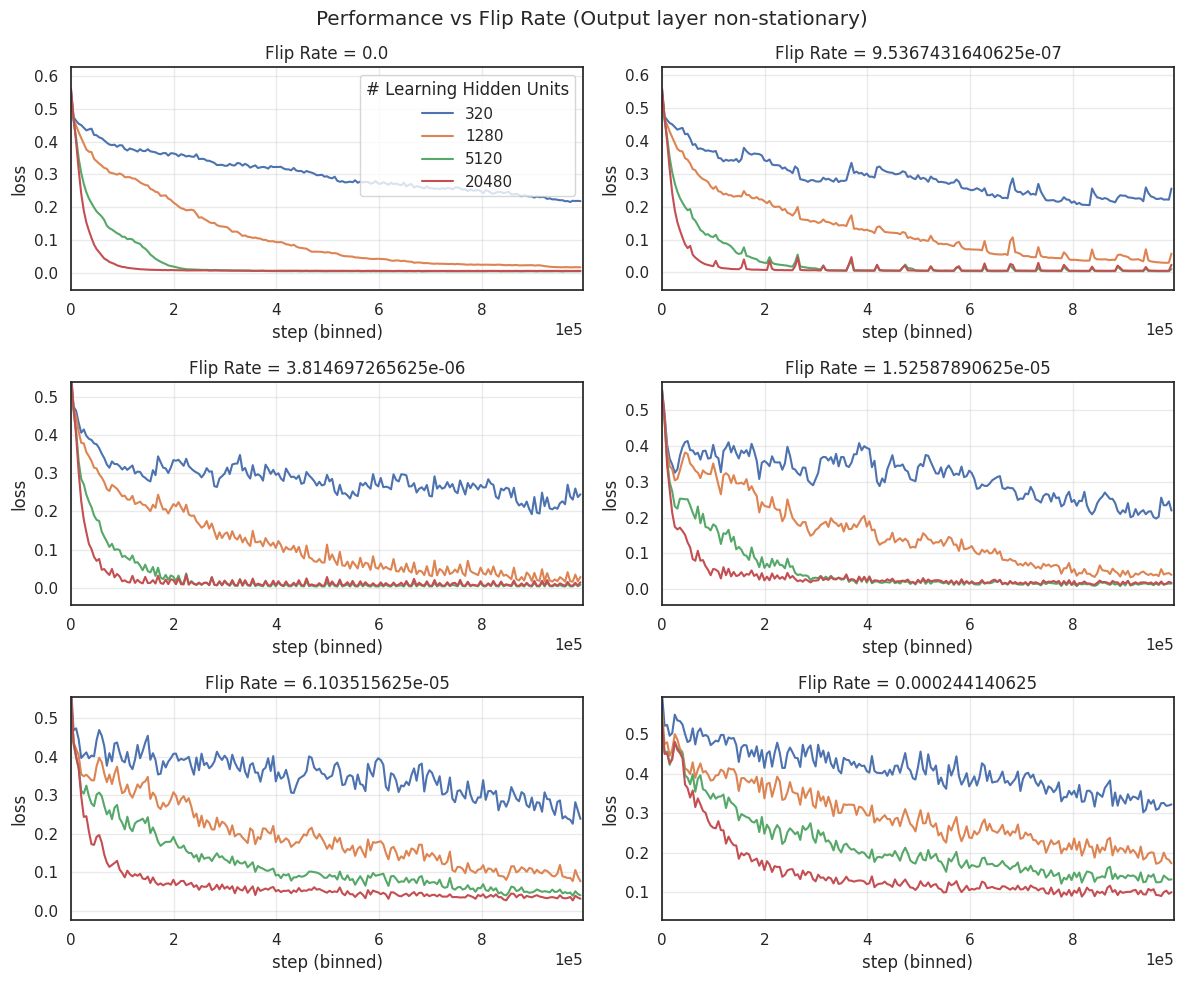

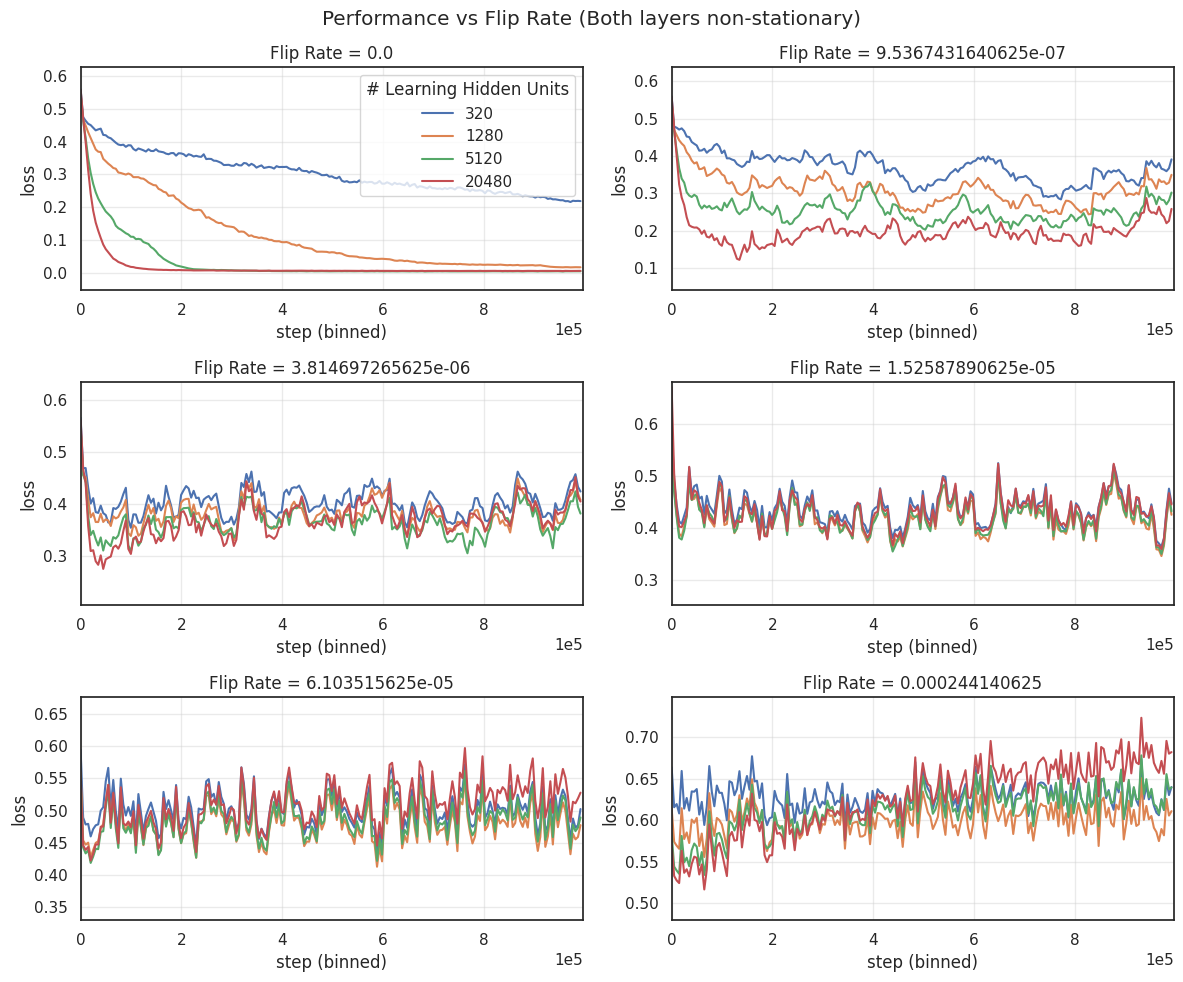

In [85]:
plot_learning_curves(
    run_df = best_run_dfs['partial_ns'],
    config_df = best_config_dfs['partial_ns'],
    subplot_col = 'task|flip_rate',
    n_bins = 200,
    figsize = (12, 10),
    max_cols = 2,
    subplot_col_label = 'Flip Rate',
    same_y_axis = False,
)
plt.suptitle('Performance vs Flip Rate (Output layer non-stationary)')

plot_learning_curves(
    run_df = best_run_dfs['full_ns'],
    config_df = best_config_dfs['full_ns'],
    subplot_col = 'task|flip_rate',
    n_bins = 200,
    figsize = (12, 10),
    max_cols = 2,
    subplot_col_label = 'Flip Rate',
    same_y_axis = False,
)
plt.suptitle('Performance vs Flip Rate (Both layers non-stationary)')